# 📌 NYC Restaurant Inspection Risk Prediction

### 🧪 Feature Engineering

In this notebook, we will:

1. **Apply Feature Engineering Decisions**  
   - Implement transformations identified during EDA (e.g., Box-Cox transformations, date-derived features).  
   - Apply encoding strategies for categorical variables based on prior analysis (e.g., one-hot encoding, Bayesian-encoding).  
   - Ensure all transformations are applied consistently using pipelines or reproducible functions.

2. **Perform Feature Selection**  
   - Use a combination of **filter methods** (e.g., correlation analysis),  
     **wrapper methods** (e.g., recursive feature elimination), and  
     **embedded methods** (e.g., feature importances from tree-based models)  
     to identify and retain the most relevant features for predicting `critical_flag`.

3. **Finalize the Feature Set**  
   - Compile the selected features and export the processed train, validation, and test sets.  
   - Ensure that transformation steps fitted on the training data are correctly applied to the validation and test sets.

### Dependencies

In [15]:
import sys
import joblib
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from os.path import join, abspath

# adding the root folder to the system path
if abspath('..') not in sys.path:
    sys.path.append(abspath('..'))

from src.path_manager import PathManager
from src.feature_engineer import FeatureEngineeringPipeline
from src.feature_selector import FeatureSelector

# path manager to handle paths
path_manager = PathManager()
clean_data_path = path_manager.clean_data_path
processed_data_path = path_manager.processed_data_path
models_path = path_manager.models_path

# ignore warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
# feature types according to NYC open data portal
dtypes = {
    'camis': 'string',
    'dba': 'string',
    'boro': 'string',
    'building': 'string',
    'street': 'string',
    'zipcode': 'string',
    'cuisine_description': 'string',
    'action': 'string',
    'violation_code': 'string',
    'violation_description': 'string',
    'critical_flag': 'string',
    'score': 'float',
    'grade': 'string',
    'inspection_type': 'string',
    'latitude': 'float',
    'longitude': 'float',
}

# date column to parse
parse_dates = ['inspection_date']

# import data
train_df = pd.read_csv(
    join(clean_data_path, 'clean_train.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    )

val_df = pd.read_csv(
    join(clean_data_path, 'clean_val.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    )

test_df = pd.read_csv(
    join(clean_data_path, 'clean_test.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    )

full_len = len(train_df) + len(val_df) + len(test_df)
print(
    f'Train: {train_df.shape} -> {round(len(train_df)/full_len*100)}%',
    f'\nValidation: {val_df.shape} -> {round(len(val_df)/full_len*100)}%'
    f'\nTest: {test_df.shape} -> {round(len(test_df)/full_len*100)}%',
)

display(train_df.head(3))

Train: (64286, 19) -> 69% 
Validation: (14388, 19) -> 15%
Test: (14433, 19) -> 16%


,key,camis,dba,boro,building,street,zipcode,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,inspection_type,latitude,longitude,inspection_id
0,40944945_24-09-15_10B,40944945,Stage 42,Manhattan,422,West 42 Street,10036,American,2015-09-24,Establishment re-opened by DOHMH.,10B,plumbing properly installed maintained anti si...,Not Critical,2.0,A,Other,40.758823,-73.993607,40944945_24-09-15
1,50015538_19-11-15_10B,50015538,American Airlines Theater,Manhattan,227,West 42 Street,10036,American,2015-11-19,Violations were cited in the following area(s).,10B,plumbing properly installed maintained anti si...,Not Critical,12.0,A,Cycle Inspection / Initial Inspection,40.756531,-73.988117,50015538_19-11-15
2,50015171_20-11-15_10F,50015171,New Amsterdam Theater,Manhattan,214,West 42 Street,10036,American,2015-11-20,Violations were cited in the following area(s).,10F,non food contact surface improperly constructe...,Not Critical,10.0,A,Cycle Inspection / Initial Inspection,40.756317,-73.987652,50015171_20-11-15


### Feature Engineering Pipeline

In [3]:
# load pipeline and transform train data
pipeline = FeatureEngineeringPipeline(df=train_df, mode='train', target='critical_flag')
transformed_train = pipeline.transform()

# save pipeline with train-specific values
pipeline_path = join(models_path, 'feature_pipeline.joblib')
joblib.dump(pipeline, pipeline_path)

print(f'\n\nShape before processing: {train_df.shape}')
print(f'Shape after processing: {transformed_train.shape}')
display(transformed_train.head(3).style.format(precision=2))

Device set to use mps:0
Feature Engineering Steps:  55%|█████▍    | 6/11 [00:03<00:03,  1.54step/s]

Feature Engineering Steps: 100%|██████████| 11/11 [00:34<00:00,  3.15s/step]




Shape before processing: (64286, 19)
Shape after processing: (64286, 43)


,dba,building,street,zipcode,cuisine_description,violation_code,critical_flag,score,inspection_month,inspection_year,avg_score_to_date,inspection_count,days_since_last,boro_brooklyn,boro_manhattan,boro_queens,boro_staten_island,action_establishment_re_closed_by_dohmh,action_establishment_re_opened_by_dohmh,action_violations_were_cited_in_the_following_area_s,grade_b,grade_c,grade_non_gradable,inspection_type_cycle_inspection_re_inspection,inspection_type_other,inspection_type_pre_permit_operational_initial_inspection,inspection_season_spring,inspection_season_summer,inspection_season_winter,desc_length_words,desc_length_chars,critical_token_count,negative_sentiment,tfidf_cleaning,tfidf_food,tfidf_material,tfidf_non_food_contact,tfidf_spaced_movable,tfidf_spaced_movable_allow,tfidf_surface_equipment,tfidf_underneath,tfidf_underneath_unit,tfidf_unit
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30075445_31-01-23_10D,0.61,0.75,0.79,0.61,0.44,0.00,0,0.44,0.00,0.89,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.23,0.25,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30075445_31-01-23_06D,0.61,0.75,0.79,0.61,0.44,1.00,1,0.44,0.00,0.89,0.12,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.14,0.14,0.38,1.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
30075445_31-01-23_04N,0.61,0.75,0.79,0.61,0.44,1.00,1,0.44,0.00,0.89,0.12,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.37,0.27,0.92,1.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [4]:
# load new pipeline and transform unseen data
loaded_pipeline = joblib.load(pipeline_path)
transformed_val = loaded_pipeline.set_mode_to_unseen(val_df).transform()

print(f'\n\nShape before processing: {val_df.shape}')
print(f'Shape after processing: {transformed_val.shape}')
display(transformed_val.head(3).style.format(precision=2))

Feature Engineering Steps: 100%|██████████| 11/11 [00:02<00:00,  5.33step/s]



Shape before processing: (14388, 19)
Shape after processing: (14388, 43)


,dba,building,street,zipcode,cuisine_description,violation_code,critical_flag,score,inspection_month,inspection_year,avg_score_to_date,inspection_count,days_since_last,boro_brooklyn,boro_manhattan,boro_queens,boro_staten_island,action_establishment_re_closed_by_dohmh,action_establishment_re_opened_by_dohmh,action_violations_were_cited_in_the_following_area_s,grade_b,grade_c,grade_non_gradable,inspection_type_cycle_inspection_re_inspection,inspection_type_other,inspection_type_pre_permit_operational_initial_inspection,inspection_season_spring,inspection_season_summer,inspection_season_winter,desc_length_words,desc_length_chars,critical_token_count,negative_sentiment,tfidf_cleaning,tfidf_food,tfidf_material,tfidf_non_food_contact,tfidf_spaced_movable,tfidf_spaced_movable_allow,tfidf_surface_equipment,tfidf_underneath,tfidf_underneath_unit,tfidf_unit
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50015880_02-07-24_10F,0.38,0.43,0.19,0.44,0.44,0.00,0,0.17,0.55,1.00,0.01,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.23,0.23,0.00,1.00,0.13,0.06,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13
41391463_02-07-24_06D,0.55,0.12,0.27,0.00,0.43,1.00,1,0.49,0.55,1.00,0.17,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.14,0.14,0.38,1.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50086558_02-07-24_08A,0.75,0.57,0.45,0.47,0.44,0.00,0,0.43,0.55,1.00,0.12,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.07,0.08,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [5]:
# load new pipeline and transform unseen data
transformed_test = loaded_pipeline.set_mode_to_unseen(test_df).transform()

print(f'\n\nShape before processing: {test_df.shape}')
print(f'Shape after processing: {transformed_test.shape}')
display(transformed_test.head(3).style.format(precision=2))

Feature Engineering Steps: 100%|██████████| 11/11 [00:02<00:00,  3.80step/s]



Shape before processing: (14433, 19)
Shape after processing: (14433, 43)


,dba,building,street,zipcode,cuisine_description,violation_code,critical_flag,score,inspection_month,inspection_year,avg_score_to_date,inspection_count,days_since_last,boro_brooklyn,boro_manhattan,boro_queens,boro_staten_island,action_establishment_re_closed_by_dohmh,action_establishment_re_opened_by_dohmh,action_violations_were_cited_in_the_following_area_s,grade_b,grade_c,grade_non_gradable,inspection_type_cycle_inspection_re_inspection,inspection_type_other,inspection_type_pre_permit_operational_initial_inspection,inspection_season_spring,inspection_season_summer,inspection_season_winter,desc_length_words,desc_length_chars,critical_token_count,negative_sentiment,tfidf_cleaning,tfidf_food,tfidf_material,tfidf_non_food_contact,tfidf_spaced_movable,tfidf_spaced_movable_allow,tfidf_surface_equipment,tfidf_underneath,tfidf_underneath_unit,tfidf_unit
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50116267_12-12-24_06A,0.60,0.54,0.42,0.61,0.31,1.00,1,0.35,1.00,1.00,0.07,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.27,0.28,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50081416_12-12-24_02B,0.57,0.69,0.57,0.47,0.44,1.00,1,0.43,1.00,1.00,0.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.04,0.00,0.15,0.00,0.00,0.12,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50145944_12-12-24_10F,0.60,0.50,0.50,0.34,0.44,0.00,0,0.47,1.00,1.00,0.15,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.23,0.23,0.00,1.00,0.13,0.06,0.13,0.13,0.13,0.13,0.13,0.13,0.13,0.13


### Feature Selection

| Method                | Type          | Description                                                                                         | Key Parameters / Criteria                              | Strengths                                 | Weaknesses                              |
|-----------------------|---------------|-------------------------------------------------------------------------------------------------|-------------------------------------------------------|-------------------------------------------|----------------------------------------|
| **Forward Selection**  | Wrapper       | Iteratively adds features that improve cross-validated model score the most; stops when no improvement occurs | Uses cross-validation score, stops when no gain       | Simple, interpretable, considers feature interactions | Computationally expensive on many features |
| **Backward Elimination** <br>[Not Used] | Wrapper       | Iteratively removes features that hurt model performance the most until reaching minimum features | Uses cross-validation score, stops at min features    | Considers all features initially, robust | Expensive, risk of removing useful features early |
| **Recursive Feature Elimination (RFE)** | Wrapper       | Removes features recursively based on model performance, removing a set number (step) each iteration | Step size controls how many features dropped at once  | More efficient than pure backward elimination | Still computationally expensive, step size tuning needed |
| **Lasso/Logistic + L1 Coefficients** | Embedded      | Uses L1 regularization to shrink some coefficients to zero, selecting features with non-zero coef | Alpha controls strength of regularization (C in Logistic regression)           | Performs feature selection and regularization simultaneously | Sensitive to feature scaling and correlated features |
| **Random Forest Importance** | Embedded      | Uses tree-based model to measure feature importance based on impurity decrease                   | Feature importance threshold (>0.005 in this case)    | Handles non-linearities, robust to correlated features | Importance can be biased towards variables with many categories |
| **Correlation Filter** | Filter        | Selects features with target correlation >0.1 (absolute) and pairwise inter-feature correlation <0.7 | Thresholds for target and inter-feature correlations   | Fast, simple, reduces redundancy          | Ignores feature interactions and non-linear relations |

In [6]:
feature_groups = {
    'Restaurant Features': [
        'dba', 'building', 'street', 'zipcode', 'cuisine_description'
    ],
    'Inspection Features': [
        'inspection_month', 'inspection_year',
        'inspection_type_cycle_inspection_re_inspection',
        'inspection_type_other',
        'inspection_type_pre_permit_operational_initial_inspection',
        'inspection_season_spring', 'inspection_season_summer',
        'inspection_season_winter', 'inspection_count',
        'avg_score_to_date', 'days_since_last', 'score', 
        'grade_b', 'grade_c', 'grade_non_gradable',
    ],
    'Location Features': [
        'boro_brooklyn', 'boro_manhattan', 'boro_queens', 'boro_staten_island'
    ],
    'Action Features': [
        'action_establishment_re_closed_by_dohmh',
        'action_establishment_re_opened_by_dohmh',
        'action_violations_were_cited_in_the_following_area_s'
    ],
    'Description Features': [
        'desc_length_words', 'desc_length_chars',
        'critical_token_count', 'negative_sentiment',
        'tfidf_cleaning', 'tfidf_food', 'tfidf_material',
        'tfidf_non_food_contact', 'tfidf_spaced_movable',
        'tfidf_spaced_movable_allow', 'tfidf_surface_equipment',
        'tfidf_underneath', 'tfidf_underneath_unit', 'tfidf_unit'
    ]
}

target_feature = 'critical_flag'

In [7]:
# exclude violation_code (since it's too dominant)
tmp_train = transformed_train.copy().drop(columns=['violation_code'])

selector = FeatureSelector(train_df=tmp_train, task='classification', target=target_feature)

In [8]:
selector.rfe_selection(step=3, min_features_to_retain=10)
print('Recursive Feature Elimination selection ready.')

RFE Selection:   0%|          | 0/11 [00:00<?, ?it/s]

RFE Selection: 100%|██████████| 11/11 [05:44<00:00, 31.34s/it]

Recursive Feature Elimination selection ready.


In [9]:
selector.forward_selection()
print('Forward selection ready.')

Forward Selection:   0%|          | 0/41 [00:00<?, ?it/s]

Forward Selection:  12%|█▏        | 5/41 [01:56<13:57, 23.26s/it]

Forward selection ready.


In [10]:
# TOO SLOW
# selector.backward_selection(min_features_to_retain=10)
# print('Backward selection ready.')

In [11]:
selector.embedded_selection()
print('Embedded selection ready.')

Embedded selection ready.


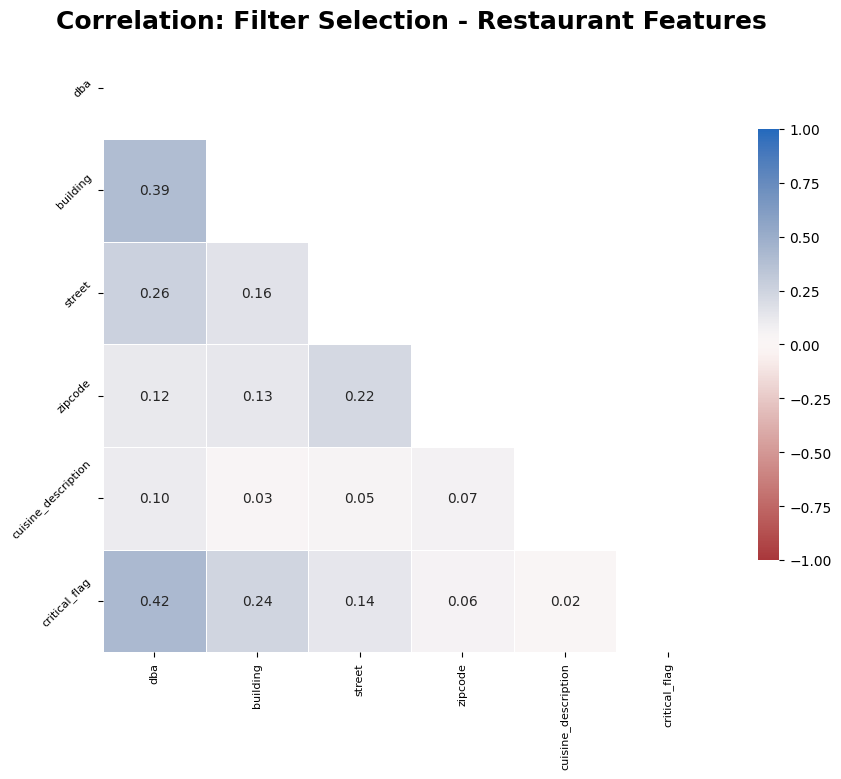

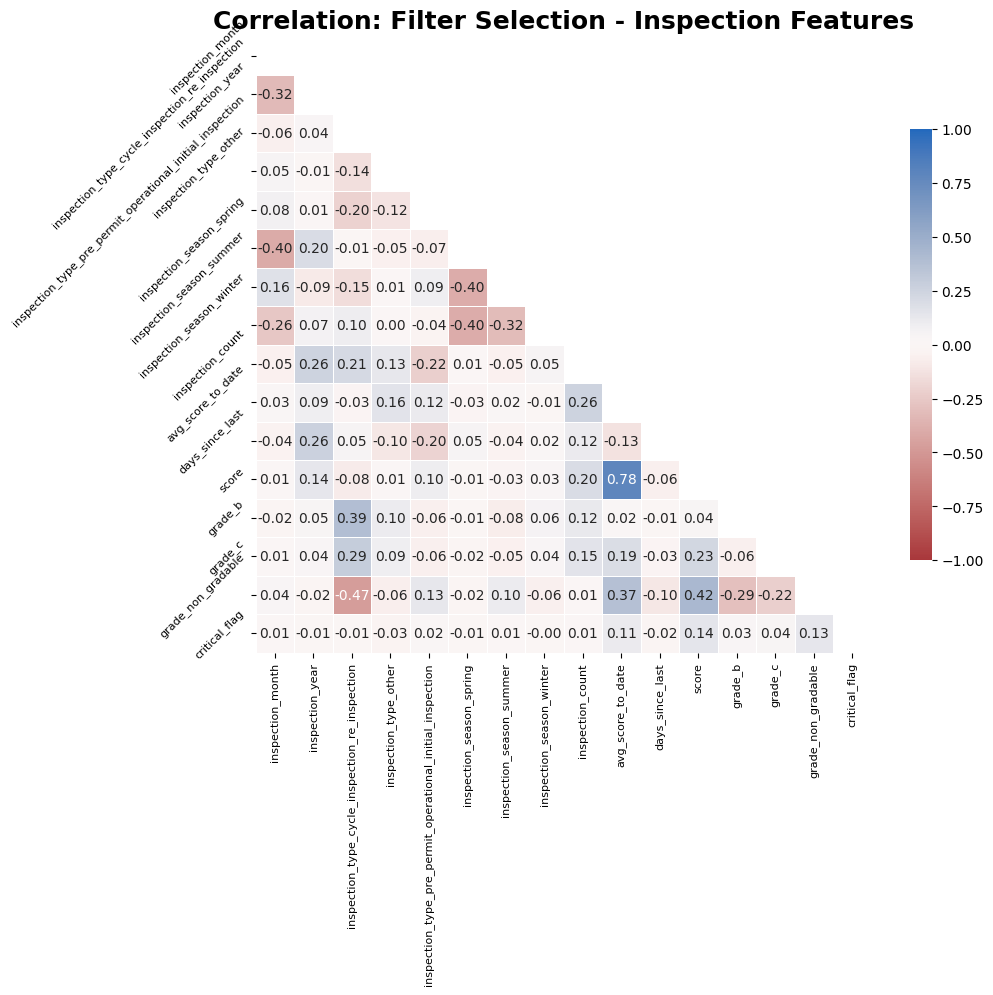

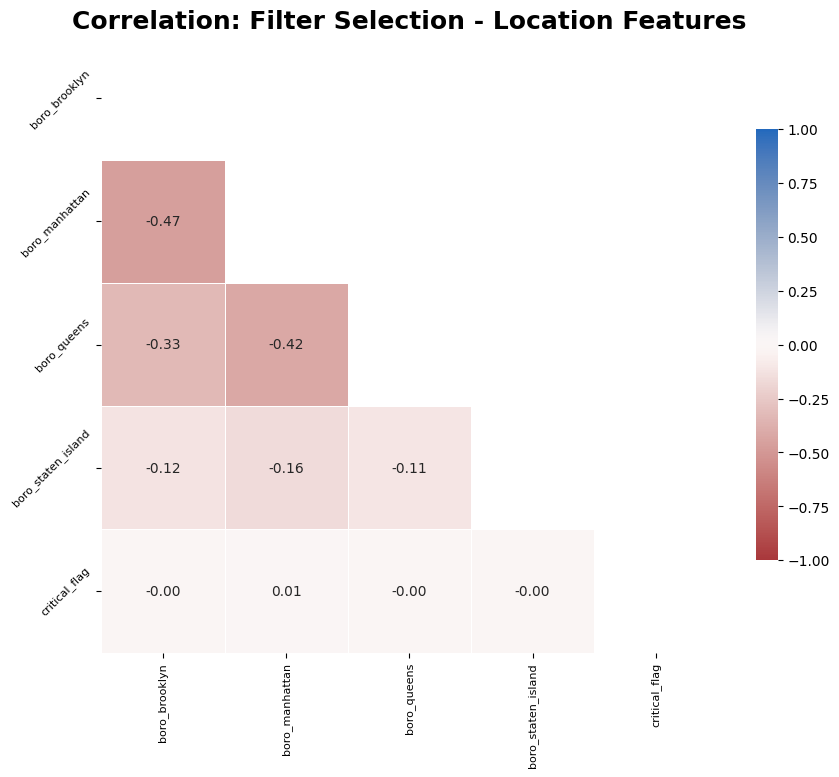

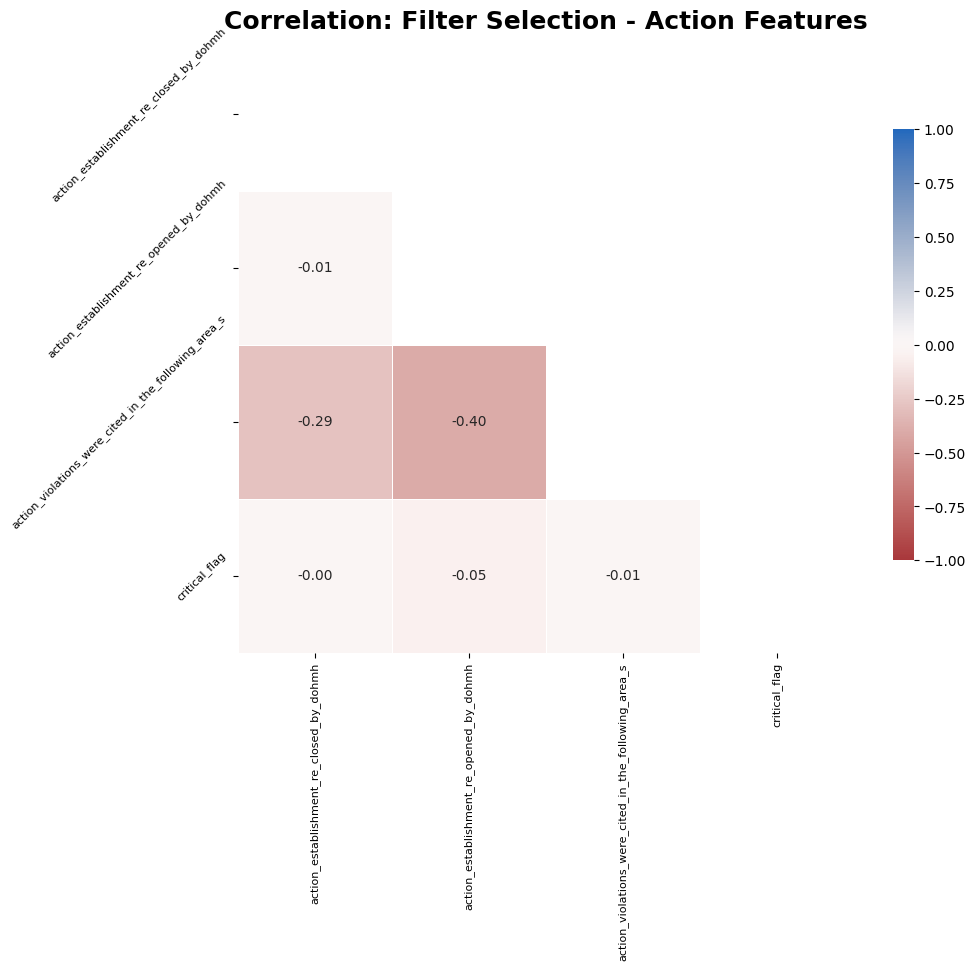

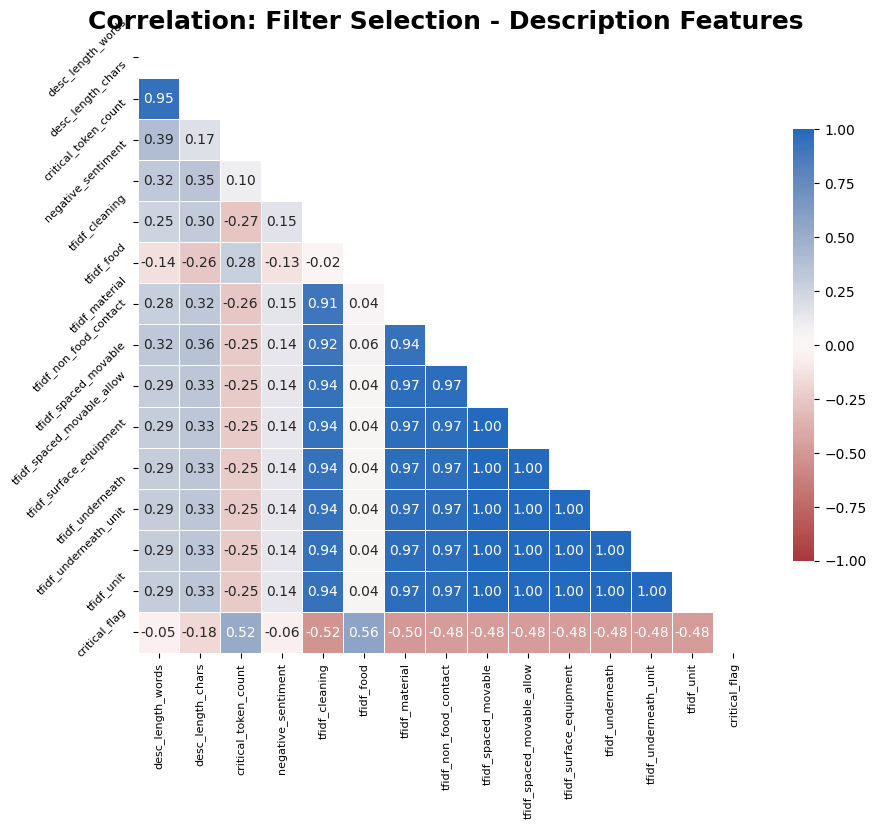

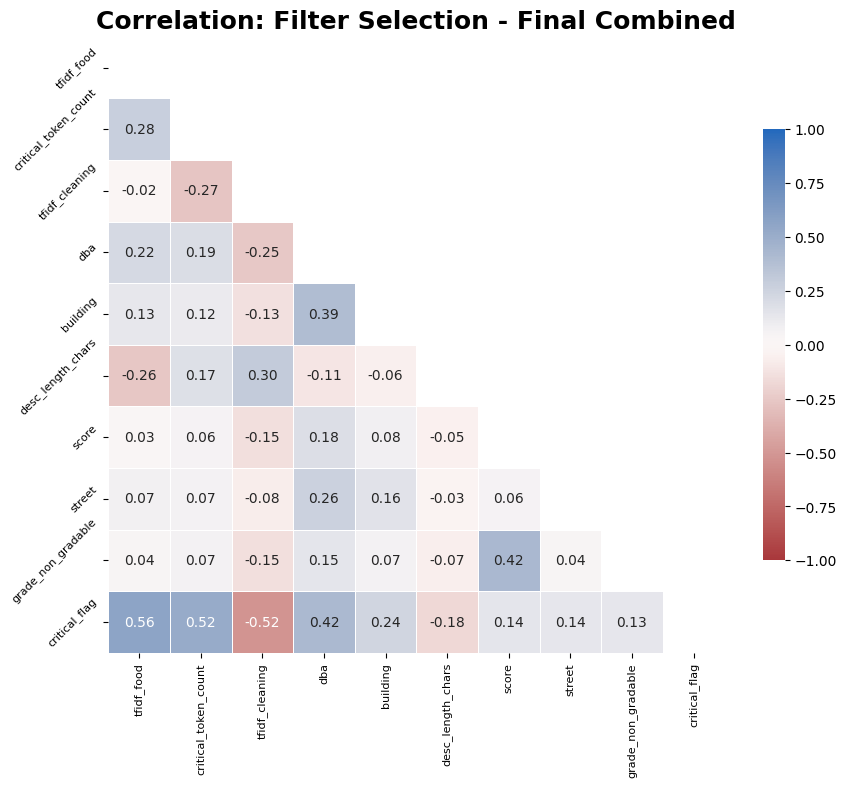

In [12]:
_ = selector.filter_selection(feature_groups=feature_groups)

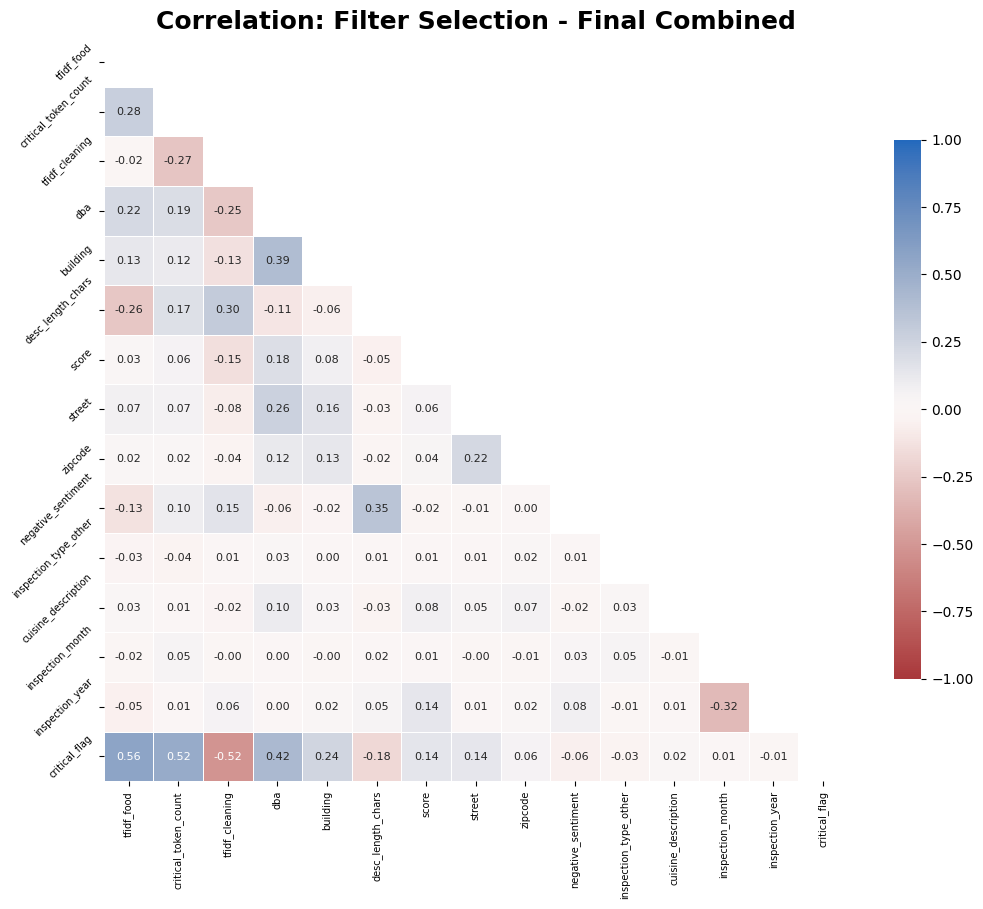

In [13]:
_ = selector.final_selection()

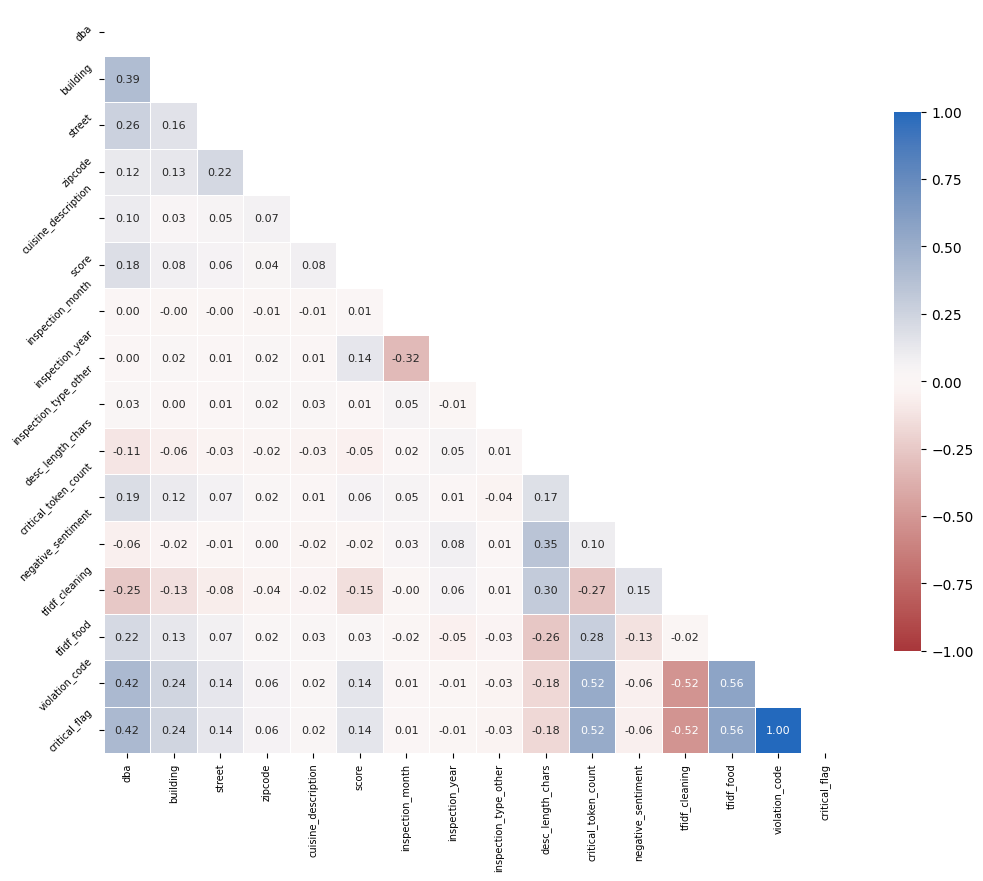

In [18]:
results_df = selector.df.copy()

selected_features = results_df.loc[results_df['Filter_Final'] == 'Keep', 'Features'].to_list()

selected_features += ['violation_code', target_feature]

data = transformed_train[selected_features].corr()

cmap = sns.color_palette('vlag_r', as_cmap=True)
mask = np.triu(np.ones_like(data, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(data, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .7},
            annot=True, fmt='.2f', annot_kws={'size': 8})

plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=45, fontsize=7)
plt.show()

In [19]:
# final feature check
transformed_train[selected_features].head(3).style.format(precision=2)

,dba,building,street,zipcode,cuisine_description,score,inspection_month,inspection_year,inspection_type_other,desc_length_chars,critical_token_count,negative_sentiment,tfidf_cleaning,tfidf_food,violation_code,critical_flag
key,,,,,,,,,,,,,,,,
30075445_31-01-23_10D,0.61,0.75,0.79,0.61,0.44,0.44,0.00,0.89,0.00,0.25,0.00,1.00,0.00,0.00,0.00,0
30075445_31-01-23_06D,0.61,0.75,0.79,0.61,0.44,0.44,0.00,0.89,0.00,0.14,0.38,1.00,0.00,0.07,1.00,1
30075445_31-01-23_04N,0.61,0.75,0.79,0.61,0.44,0.44,0.00,0.89,0.00,0.27,0.92,1.00,0.00,0.07,1.00,1


In [20]:
# save results
transformed_train[selected_features].to_csv(join(processed_data_path, 'processed_train.csv'))
transformed_val[selected_features].to_csv(join(processed_data_path, 'processed_val.csv'))
transformed_test[selected_features].to_csv(join(processed_data_path, 'processed_test.csv'))